In [249]:
import math
import numpy as np
import pandas as pd
import sys
import re
import itertools
from functions import *
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as sklearnLDA
from scipy.spatial.distance import cdist
import scipy.cluster.hierarchy
import jellyfish as jf
import seaborn as sns
np.set_printoptions(precision=2)
pd.set_option('precision', 2)
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10, 3)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data wrangling

#### Loaded dataframe with every actions for all students and dataframe with student pre/post scores

In [2]:
df.head(2)

,Activity,student,Time Stamp,Family,Family_tool,Family_default,Family_both,Action,Component,Outcome,...,current_is_circuit,current_#loops,current_#components,current_#battery,current_#circuitSwitch,current_#grabBagResistor,current_#lightBulb,current_#resistor,current_#seriesAmmeter,non_default_resistor_values
0,a2,10009106,1363981168331,Construct,Construct,Construct,Construct,add,wire,None,...,0,0,0,0,0,0,0,0,0,0
1,a2,10009106,1363981175425,Construct,Construct,Construct,Construct,add,battery,None,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df_scores.head(2)

,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,...,Anon Student Id,incoming_knowledge,incoming_attitude,learning1score,learning1,learning2score,learning2,split pre,split post t2,three groups
0,March,not,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,high,low,NaN,low,NaN,low,high,high,HH
1,March,scaff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,high,low,NaN,low,NaN,low,high,high,HH


#### Crop activity data to get rid of activity #3

In [4]:
max_time = 25*60*1000
max_times = {s:min(df[df['student']==s]["Time Stamp"])+max_time for s in set(df['student'])}

def keep_by_time (row):
    if row["Time Stamp"] <= max_times[row["student"]]:
        return True
    else: 
        return False

df['keep'] = df.apply (lambda row: keep_by_time (row),axis=1)
df=df[df['keep']]

#### Define LL, LH, HL and HH groups based on median split on pre and bimodal dist of post tests

In [5]:
median_learning0 = 0.45
df_scores['split pre'] = df_scores.apply (lambda row: label_learning (median_learning0,row,"z pre"),axis=1)
median_learning2 = np.median(df_scores[df_scores['split pre']=='low']['z post t2'])
df_scores['split post t2'] = df_scores.apply (lambda row: label_learning (median_learning2,row,"z post t2"),axis=1)

In [6]:
for x in ['high','low']:
    for y in ['high','low']:
        print x,y, len(set(df_scores[(df_scores['split pre']==x)&(df_scores['split post t2']==y)]['student']))

high high 22
high low 3
low high 38
low low 36


In [7]:
def label_3_groups (row):
    if row['split pre']  == 'high' and row['split post t2'] == 'high':
        return 'HH'
    if row['split pre']  == 'high' and row['split post t2'] == 'low':
        return 'HL'
    if row['split pre']  == 'low' and row['split post t2'] == 'high':
        return 'LH'
    if row['split pre']  == 'low' and row['split post t2'] == 'low':
        return 'LL'
df_scores['three groups'] = df_scores.apply (lambda row: label_3_groups (row),axis=1)

#### Convert action families into string sequences

In [16]:
def convert(action, test_granular = True):
        
    '''
    this function converts action families into single codes more amenable for sequence interpretation
    '''

    if test_granular:
        converter =  {"Construct" : "C",
        "Interface" : "I",
        "Pause" : "P",
        "Test_basic" : "T1",
        "Test_complex" : "Tm",
        "Test_other" : "To",
        "Test_simple" : "T2",
        }
    else:
        converter =  {"Construct" : "C",
        "Interface" : "I",
        "Pause" : "P",
        "Test_basic" : "T",
        "Test_complex" : "T",
        "Test_other" : "T",
        "Test_simple" : "T",
        }   
    return converter[action]

In [17]:
''' 
this is a test cell to assess regex
'''
ignore=['I', 'To']
sequence = list(df[df['student']==10009106]["Family"])

#prints raw sequence
print ''.join([convert(action) for action in sequence if convert(action) not in ignore])

#prints blocked action sequence
block = re.sub(r'([A-Z][a-z]{0,3})\1+', 
               r'\1',
               ''.join([convert(action, False) for action in sequence if convert(action, False) not in ignore]))
print block

#prints blocked action for all action families except tests
block2 = re.sub(r'([CPI])\1+', 
                r'\1',
                ''.join([convert(action) for action in sequence if convert(action) not in ignore]))
print block2

CCCPCCCCCCCCCCCCCCCCCCCCCCCCTmCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCT1T1PT1T1PT1CCCCCCCT1T1T1CCCCCCT1PT2T2T2T2PT2T2T2PT2T2PT2PT2T2T2T2CCT2T2T2T2CCT2T2T2T2T2T2PCCCCT2T2T2T2T2T2T2T2CT2T2T2T2T2T2T2PCCT2T2T2T2T2T2CT2T2T2T2T2T2T2PPCCCCCCCC
CPCTCTPTPTCTCTPTPTPTPTPTCTCTPCTCTPCTCTPC
CPCTmCT1T1PT1T1PT1CT1T1T1CT1PT2T2T2T2PT2T2T2PT2T2PT2PT2T2T2T2CT2T2T2T2CT2T2T2T2T2T2PCT2T2T2T2T2T2T2T2CT2T2T2T2T2T2T2PCT2T2T2T2T2T2CT2T2T2T2T2T2T2PC


In [340]:
'''
This creates dictionary (keys are student ID) and values are action sequences
'''
ignore=['I', 'To']
students = list(df['student'].unique())
sequences = {student:'' for student in students}
for student in students:
    sequence = list(df[df['student']==student]["Family"])
    sequences[student] = re.sub(r'([A-Z][a-z]{0,3})\1+', 
                                r'\1',
                                ''.join([convert(action) for action in sequence if convert(action) not in ignore]))

In [240]:
'''
This creates a list of possible 3 action "phrases" (short sequences of actions) that will define
the dimensions along which we will cluster students.  The phrases cannot contain the same action in a row.
'''
# actions = ['C','P','T1','T2','Tm']
actions = ['C','P','T']
phrases = []    
for action1 in actions:
    temp2 = actions[:]
    temp2.remove(action1)
    for action2 in temp2:
        temp3 = actions[:]
        temp3.remove(action2)
        for action3 in temp3:
#             temp4 = actions[:]
#             temp4.remove(action3)
#             for action4 in temp4: 
                phrases = phrases + [action1+action2+action3]

print len(phrases)             
print phrases

12
['CPC', 'CPT', 'CTC', 'CTP', 'PCP', 'PCT', 'PTC', 'PTP', 'TCP', 'TCT', 'TPC', 'TPT']


In [241]:
#testing regex for detecting number of instances a phrase appears in a student whole sequence
s = sequences[1075123]
matches = re.finditer(r'(?=(CTC))',s)
results = [match.group(1) for match in matches]
print len(results)

19


In [242]:
'''
This creates a large matrix where each row is a student and each column represent a phrase.  
Each element is the normalized count of instances that the corresponding phrase appears
in that students whole sequence.
'''
# phrases = ['CPCTC', 'CPCTCP', 'TCTC', 'TCPCP', 'CTCT', 'PTPCT', 'PTCT', 'TPTC', 'TPCPCP', 'TPCT']
# phrases = ['TP','CP', 'PC', 'PT', 'CT', 'TC']
X=np.zeros([len(students),len(phrases)])
nn = 0
for student in students:
    mm = 0
    for phrase in phrases:
        rx = r'(?=({0}))'.format(phrase)
        matches = re.finditer(rx,sequences[student])
        X[nn,mm] = len([match.group(1) for match in matches]) / float(len(sequences[student]))
        mm += 1
    nn += 1  

In [243]:
# n_components=2
sklearn_pca = sklearnPCA()
pca = sklearn_pca.fit(X)
# transformed_X = np.dot(X, pca.components_.T)
X_tr = sklearn_pca.fit_transform(X)
# plt.figure(figsize=(5, 6))
# plt.scatter(transformed_X[:,0],transformed_X[:,1])
# plt.scatter(X_tr[:,0],X_tr[:,1])
print(pca.components_[1:3,:]) 
print(pca.explained_variance_ratio_)

[[ 0.36 -0.14  0.55 -0.25  0.1  -0.07 -0.06 -0.36  0.11  0.37 -0.33 -0.28]
 [ 0.17 -0.37  0.02  0.41 -0.13  0.59 -0.22 -0.34 -0.07 -0.16  0.27 -0.19]]
[5.03e-01 2.48e-01 1.06e-01 5.67e-02 4.74e-02 3.26e-02 3.09e-03 2.17e-03
 1.02e-03 2.38e-04 6.49e-05 1.92e-32]


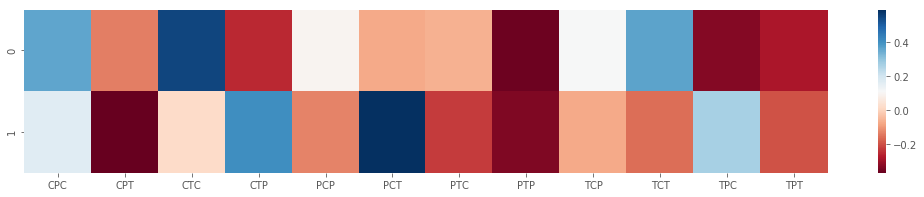

In [244]:
plt.figure(figsize=(18, 3))
ax = sns.heatmap(pca.components_[1:3,:], cmap="RdBu", xticklabels=phrases)

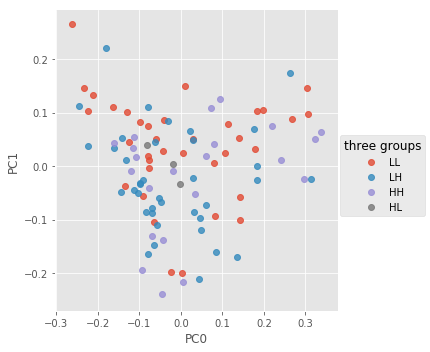

In [245]:
df_action_counts = pd.DataFrame(X_tr)
df_action_counts.columns = ['PC'+ str(nn) for nn in range(0,X_tr.shape[1])]
df_action_counts['student'] = students
# df_action_counts.head()
df_category = df_scores.loc[:,['student','three groups']]
df_action_counts = df_action_counts.join(df_category.set_index('student'), on='student')
# df_action_counts.head()
sns.lmplot('PC0', 'PC1', data=df_action_counts, hue='three groups', fit_reg=False)

In [246]:
# n_components=2
sklearn_lda = sklearnLDA()
y = df_action_counts['three groups'].values
lda = sklearn_lda.fit(X, y)
X_tr_lda = sklearn_lda.fit_transform(X, y)
print(lda.coef_) 
print(lda.explained_variance_ratio_)

[[ 39.59  -8.63  44.76  -5.2  -39.45 -19.07  74.89  17.08 -69.66 -47.53
   28.44 -13.74]
 [ 62.54 -15.48  30.91  17.4   -9.82 -19.09  32.28  60.04  39.01  29.52
   86.15   3.89]
 [ -9.66   2.42  -3.76  12.97   5.22 -14.29 -26.38  -6.92  25.73   0.29
    1.95   5.39]
 [-19.2    4.01 -25.96 -11.96  19.42  28.32 -20.61  -8.14  12.16  26.29
  -26.61   2.38]]
[0.58 0.33 0.08]


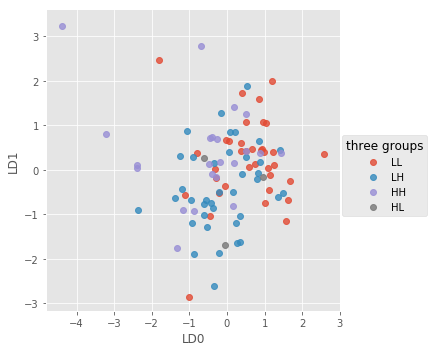

In [247]:
df_action_counts2 = pd.DataFrame(X_tr_lda)
df_action_counts2.columns = ['LD'+ str(nn) for nn in range(0,X_tr_lda.shape[1])]
df_action_counts2['student'] = students
# df_action_counts2.head()
df_action_counts2 = df_action_counts2.join(df_category.set_index('student'), on='student')
sns.lmplot('LD0', 'LD1', data=df_action_counts2, hue='three groups', fit_reg=False)

In [234]:
K=2
# Number of clusters
kmeans = KMeans(n_clusters=K)
# Fitting the input data
kmeans = kmeans.fit(X)
# Getting the cluster labels
labels = kmeans.predict(X)
# Centroid values
centroids = kmeans.cluster_centers_

In [235]:
for nn in range(0, K):
    print len([label for label in labels if label == nn])

30
69


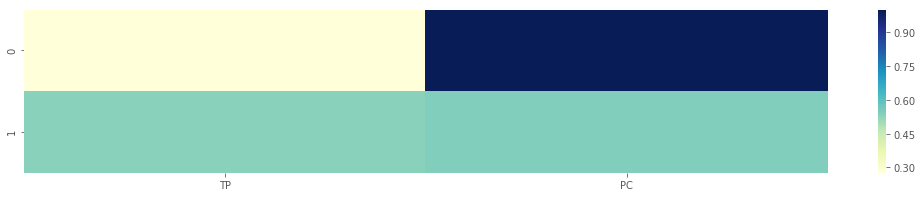

In [236]:
plt.figure(figsize=(18, 3))
ax = sns.heatmap(centroids/np.max(centroids[:]), cmap="YlGnBu", xticklabels=phrases)

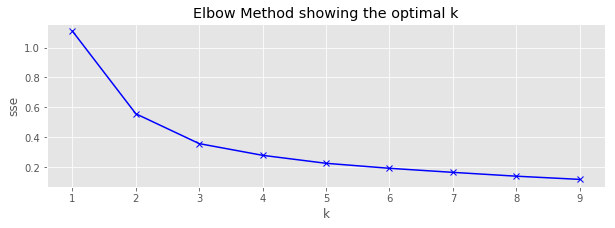

In [237]:
# k means determine k
sse = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
#     sse.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'sqeuclidean'), axis=1)))
    sse.append(kmeanModel.inertia_)

plt.plot(K, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('sse')
plt.title('Elbow Method showing the optimal k')
plt.show()

#### Creating new dataframe with clusters and pre-identified groups

In [238]:
df2 = pd.DataFrame(np.array([students,labels]).transpose())
df2.columns = ['student','k-means label']
df_category = df_scores.loc[:,['student','three groups']]
df2 = df2.join(df_category.set_index('student'), on='student')
df2.head()

,student,k-means label,three groups
0,10009106,1,LL
1,1075123,1,LH
2,10942128,0,LH
3,12235124,1,LL
4,12949120,1,LH


In [239]:
df2.groupby(['k-means label', 'three groups']).size().unstack().fillna(0)

three groups,HH,HL,LH,LL
k-means label,,,,
0,9.0,0.0,8.0,13.0
1,13.0,3.0,30.0,23.0


In [338]:
print sentences[35]
print sentences[40]
print len(sentences)

CPCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCPTTTTPCCCCCCTTTTTCPCCCCCCCCCCCCCTTTTTTTTTCCTPCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCPCCCCCCCCCCPCCCPCCCCCCCPTTTTTTTPCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCPCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCPCCCCCCCCCCCCCCCCCPCCCCCCCPTTTTCCCCCTTTCCCCCCCCCCCCCCTTTTTTTCCCCCCCTTTTPCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCPTTTTTCCCCCTTCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCPCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCPCCCCCCCCCPCCCCCCCCCCCCCCCCCCPCCPCCCCC
CCCCCCCCCCCCCPCCCCCCCCCCCCCCCCCCCCCCCPCCCCCCCPCCPCCCCCCPCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTPTCCCTTPCCCCPCCCCCCCCCCCCCCCCPCCCCCCCCCCCCCCCCCCCCPCCCCCCCPCCCCCCCTCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCPCCCCCCCCCCCCCCCCCCCCCTTTTTTTTPCCCCCCCCCCCCTTTTTTCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCPCCCCCCCTTTTCCCCCCCCCPCCCCCPCTCTCCCCCCTTTCCCCCCCCCCCCCPCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCPCCCPCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCPCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCPTCCCCCCCCCCCCCPCCCCCCCCCCCCCCCC
99


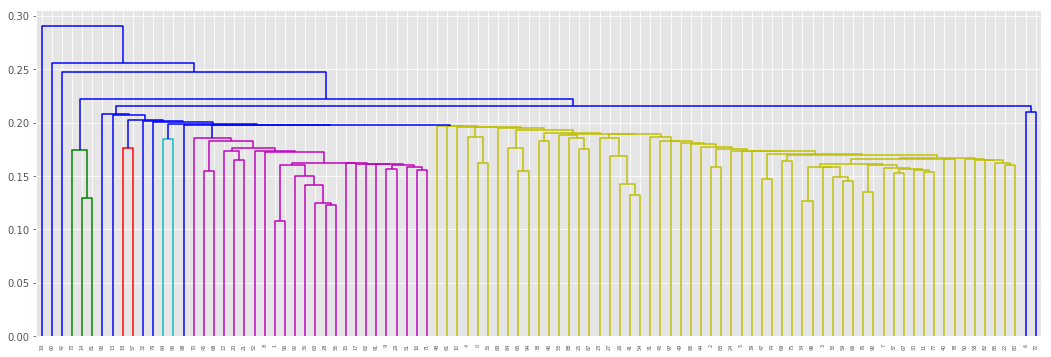

In [349]:
sentences = map(unicode, sequences.values())

def distmetric(coord):
    i, j = coord
    return 1 - jf.jaro_distance(sentences[i], sentences[j])

coord = np.triu_indices(len(sentences), 1)
distmatrix = np.apply_along_axis(distmetric, 0, coord)
Z = scipy.cluster.hierarchy.linkage(distmatrix)
plt.figure(figsize=(18, 6))
max_d = 0.68*max(Z[:,2])
results = scipy.cluster.hierarchy.dendrogram(Z, color_threshold = max_d)

In [350]:
clusters = scipy.cluster.hierarchy.fcluster(Z, max_d, criterion='distance')
print clusters

[ 5  4  5  5  5  5 11  5  4  4  5  5  4  9  1  4  4  4  2 15  4  4  5  5
  5  5  5  5  4  4  5  5  8  5  5  5  4  5  5  5  5  5 13  5  5  4  5  5
  5  5  5  4  4  5  5  4  4  2  5  5 14  5  4  4  3  5  5  5  4  5  4  4
 12  1  5  5  5  5  5  7  5  1  5  5  5  5  5  5  5  5  5  4  4 10  5  3
  5  5  6]


In [353]:
df3 = pd.DataFrame(np.array([students,clusters]).transpose())
df3.columns = ['student','hierarchical label']
df_category3 = df_scores.loc[:,['student','three groups']]
df3 = df3.join(df_category3.set_index('student'), on='student')
# df3[df3['three groups']=='LH']
df3.groupby(['hierarchical label', 'three groups']).size().unstack()

three groups,HH,HL,LH,LL
hierarchical label,,,,
1,NaN,1.0,NaN,2.0
2,NaN,NaN,1.0,1.0
3,NaN,1.0,NaN,1.0
4,5.0,NaN,9.0,10.0
5,14.0,1.0,24.0,19.0
6,1.0,NaN,NaN,NaN
7,NaN,NaN,1.0,NaN
8,NaN,NaN,NaN,1.0
9,1.0,NaN,NaN,NaN
